In [13]:
from tqdm import trange

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


import torch
import torch.optim as optim
import torch.nn as nn
import transformers

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [1]:
! pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://download.pytorch.org/whl/nightly/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 MB 2.5 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 2.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 646.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.7 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 kB 1.4 MB/s eta 0:00:0000:0100:01


# 1. Выбор пайплайна и модели классификации

В качестве моделей рассматриваются следующие виды.
1. **Логистическая регрессия**. Является простой моделью. При наличии хороших эмбедингов может показать неплохую точность особенно в задачах с небольшим количеством классов. Явными плюсами являются быстрое обучение, простота модели, легковесность модели, скорость работы. 
2. **DAN (Deep Averaging Network)**. Также является простой моделью, являющаяся нейронной сетью с 2мя слоями. Для данной модели можно выделить следующие достоинства: простота реализации и относительная простота обучения, хорошая точность в задачах с небольшим числом классов. Reference: "Mohit Iyyer, Varun Manjunatha, Jordan Boyd-Graber, Hal Daume III // Deep Unordered Composition Rivals Syntactic Methods for Text Classification"
3. **RNN**. Рекуррентные нейронные сети – сильные модели, требующие большое количество данных и ресурсов на обучение. Способны решать сложные задачи классификации. Однако данный вид моделей имеет много недостатков и для подобной "простой" классификации избыточен.
4. **CNN**. Сверточные нейронные сети – не менее сильные модели, требующие меньше ресурсов по сравнению с RNN. CNN позволяет учитывать локальный контекст слов без явного использования словарных N-грамм. Хорошо подходит как для улучшения качества классификации базовых моделей.

Для обучения первой модели считаю оптимальным выбором DAN за простоту реализации и обучения. Данную модель далее будем использовать как бейзлайн для сравнения с другими моделями.
Для относительного сравнения полученной модели будем обучать логистическую регрессию как наиболее простую модель.

# 2. Выбор функции потерь и метрик для оценивания результатов классификации

Данный датасет имеет 3 класса: 0 – NEUTRAL, 1 – POSITIVE, 2 – NEGATIVE.

Функцией потерь для DAN будет являться:
$$E(w) = \frac{1}{n}\sum_{i=1}^n L(F,(x^{(i)},\sigma^{(i)}))=-\frac{1}{n}\sum_{i=1}^n\sum_{k=1}^{K=3}\sigma_k^{(i)}\ln F_k(x^{(i)})\rightarrow\min_w$$
где:
- $F$ – распределение вероятностей прогнозов модели;
- $L(F,(x,\sigma))$ – функция потерь;
- $K=3$ – количество классов;
- $\sigma$ – распределение истинных ответов;
- x – экземпляр датасета;
- w – набор гиперпараметров модели, которые корректрируются в процессе обучения.

Для оценивания результатов классификации выбраны следующие метрики:
- ROC AUC в качестве общемодельной метрики;
- f1 score с параметром $\beta=1$;
P.S. используется и микро- и макро- усреднение.

In [3]:
def get_metrics(y_pred, y_prob, y_true):
    acc_score = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_prob, multi_class="ovo")
    resut_dict = {"acc_score": acc_score, 
                  "f1_macro": f1_macro, 
                  "f1_micro": f1_micro, 
                  "roc_auc": roc_auc}
    return resut_dict


In [4]:
def compare(models_names, *args):
    values = [list(arg.values()) for arg in args]
    columns = [list(arg.keys()) for arg in args]
    return pd.DataFrame(data=values, columns=columns, index=models_names)

# 3. Подготовка датасета к обучению

Preprocessing pipline:
1. Удаление пунктуации.
2. Приведение к нижнему регистру.
3. Удаление стоп-слов.
4. Получение эмбедингов из rubert-tiny2
5. Разбиение выборки на тренировочную, валидационную и тестовую

In [4]:
df = pd.read_csv("../data/datasets.csv")

In [5]:
russian_stopwords = stopwords.words("russian")
mystem = Mystem() 

def clean(sentence):
    # удаление всех символов, не являющихся буквами или цифрами
    sentence = re.sub("[^0-9a-zA-Zа-яА-Я]+", " ", sentence)
    
    # приведение к нижнему ригистру
    sentence = sentence.lower()

    # удаление лишних пробелов в тексте
    sentence = re.sub("  ", " ", sentence)

    # замена буквы ё на е
    sentence = re.sub("ё", "е", sentence)

    # удаление переносов строки
    sentence = re.sub("\n", ".", sentence)

    # удаление стопслов
    tokens = mystem.lemmatize(sentence)
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    res_sentence = " ".join(tokens)
    
    return res_sentence

In [4]:
cleaned_df = df.copy(deep=True)
cleaned_df["text"] = df["text"].apply(clean)

In [5]:
# One-hot encoding для меток классов
data = pd.get_dummies(cleaned_df, columns = ['sentiment'], drop_first=False)

In [76]:
# Сохранение полученных данных 
data.to_csv("../data/prepeared_data.csv")

In [5]:
data = pd.read_csv("../data/prepeared_data.csv")[["text", "sentiment_0", "sentiment_1", "sentiment_2"]]
data.head()

,text,sentiment_0,sentiment_1,sentiment_2
0,развод деньги наблюдаться лайфклиника беременн...,0,1,0
1,отель выбирать рядом стадион отель 4 номер бол...,1,0,0
2,вылечивать гноиться рождение глазик поликлиник...,0,1,0
3,хороший расположение вокзал доходить пешком но...,1,0,0
4,отличный месторасположение прекрасный вид особ...,0,1,0


In [6]:
# очищение данных с пропусками
data = data.dropna()

In [7]:
# получаем предложения и метки
x_sentence = data["text"]
y = data[["sentiment_0", "sentiment_1", "sentiment_2"]].to_numpy()

In [8]:
# инициализация rubert-tiny2 модели эмбедингов
model_name = "cointegrated/rubert-tiny2"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)

In [9]:
def get_embeddings_rubert(x):
    tokenized = tokenizer(x, padding=True, truncation=True, return_tensors="pt")
    embeddings = model(**tokenized, output_hidden_states=True).hidden_states[0].sum(axis=1)
    return embeddings

In [251]:
# получение эмбедингов для всего датасета
res_x = []
for i in trange(x_sentence.shape[0]):
    sent_i = x_sentence.iloc[i]
    embedding = get_embeddings_rubert(sent_i)
    res_x.append(embedding.detach().numpy())

res_x = np.array(res_x)
res_x = res_x.reshape((res_x.shape[0], 312))

100%|██████████| 210977/210977 [24:38<00:00, 142.73it/s]


In [10]:
# получение меток (для логистической регрессии в виде массива с индексом класса)
y_tags = y.argmax(axis=1)

In [489]:
pd.DataFrame(res_x).to_csv("../data/embeddings.csv")

In [11]:
embeddings = pd.read_csv("../data/embeddings.csv", index_col=0).to_numpy()
embeddings.shape

(210977, 312)

# 4. Логистическая регрессия

In [16]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, y_tags, test_size=0.25, random_state=42)

In [17]:
from sklearn.linear_model import LogisticRegression
# 100 итераций обучения 
clf = LogisticRegression(random_state=42, max_iter=100).fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
# получаем метрики качества
y_pred_logreg = clf.predict(X_test)
y_prob_logreg = clf.predict_proba(X_test)
log_reg_metrics = get_metrics(y_pred_logreg, y_prob_logreg, y_test)

In [34]:
import joblib
joblib.dump(clf, "../models/log_reg.pkl")

['../models/log_reg.pkl']

# 5. DAN

In [14]:
# разбиение данных на  обучающую, валидационную и тестовую выборки в соотношении 0.6 : 0.2 : 0.2
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [15]:
class DAN(nn.Module):
    """
    Класс нейронной сети – DAN.
    Состоит из 2х линейных слоев с droput 
    """

    def __init__(self,
                 d_embed=312,
                 d_hidden=156,
                 d_out=3,
                 dp=0.2):
        super(DAN, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Создания 2х слоев NN
        self.dropout_1 = nn.Dropout(dp)
        self.batch_norm_1 = nn.BatchNorm1d(d_embed)
        self.lin_layer_1 = nn.Linear(d_embed, d_hidden)
        self.dropout_2 = nn.Dropout(dp)
        self.batch_norm_2 = nn.BatchNorm1d(d_hidden)
        self.lin_layer_2 = nn.Linear(d_hidden, d_out)
        self.softmax = nn.Softmax()

        # Инициализация весов для линейных слоев по методу Xavier/Glorot
        nn.init.xavier_normal_(self.lin_layer_1.weight)
        nn.init.xavier_normal_(self.lin_layer_2.weight)

    def forward(self, x):

        x = self.dropout_1(x)
        x = self.batch_norm_1(x)
        x = self.lin_layer_1(x)
        x = self.dropout_2(x)
        x = self.batch_norm_2(x)
        x = self.lin_layer_2(x)

        return self.softmax(x)

In [16]:
class Dataset(torch.utils.data.Dataset):
  """
  Класс датасета с x, y – np.array или pd.Series
  """

  def __init__(self, x, y):
        self.x = x
        self.y = y

  def __len__(self):
        return len(self.x)

  def __getitem__(self, index):
        return torch.tensor(self.x[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_losses = []

    # Обучение на mini-batch
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss.detach().numpy())

    # Валидация
    model.eval()
    val_pred = model(torch.tensor(X_val).to("cpu", dtype=torch.float32))
    val_loss = loss_fn(val_pred, torch.tensor(y_val).to("cpu", dtype=torch.float32)).detach().numpy()

    return np.average(train_losses), val_loss

In [18]:
# Параметры оптимизатора
optimizer_params = {
    "lr": 0.01,             
    "weight_decay": 1e-5    # используется L2 регуляризация для избежания переобучения
}

dataloader_params = {
    'batch_size': 50000,    # размер каждого минибетча – 50000 
    'shuffle': True         # данные выбираются случайным образом (а не по порядку)
    }

model = DAN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), **optimizer_params)

training_set = Dataset(X_train, y_train)

training_generator = torch.utils.data.DataLoader(training_set, **dataloader_params)

In [19]:
epochs = 100

train_losses = []
val_losses = []

for epoch_i in trange(epochs):
    train_loss, val_loss = train_loop(training_generator, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

  0%|          | 0/100 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


In [28]:
torch.save(model.state_dict(), "../models/DAN")

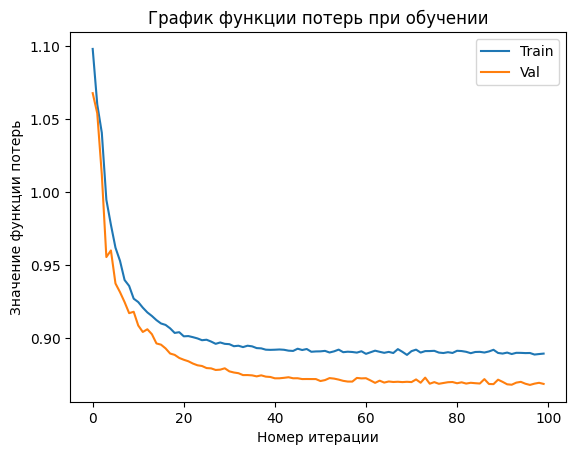

In [25]:
val_losses_list = [i.tolist() for i in val_losses]
train_losses_list = [i.tolist() for i in train_losses]
plt.plot(np.arange(len(train_losses_list)).tolist(), train_losses_list, label="Train")
plt.plot(np.arange(len(val_losses_list)).tolist(), val_losses_list, label="Val")
plt.title("График функции потерь при обучении")
plt.xlabel("Номер итерации")
plt.ylabel("Значение функции потерь")
plt.legend()

In [26]:
# получаем метрики качества
y_prob_dan = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
y_pred_dan = y_prob_dan.argmax(axis=1)
real_indexes = y_test.argmax(axis=1)
dan_metrics = get_metrics(y_pred_dan, y_prob_dan, real_indexes)

In [27]:
df = compare(["log reg", "DAN"], log_reg_metrics, dan_metrics)
df

,acc_score,f1_macro,f1_micro,roc_auc
,acc_score,f1_macro,f1_micro,roc_auc
log reg,0.665314,0.637165,0.665314,0.834108
DAN,0.666793,0.643699,0.666793,0.801716


В результате модели Логистической регрессии и DAN показали схожие результаты на одинаковых эмбедингах. 
Для более точной оценки обобщающих способностей данных моделей требуется провести серию обучений моделей (например по методу K-Fold).

# 6. Подведение итогов

В результате проделанной работы были обучены 2 классификатора: Логистическая регрессия и DAN.
Оба классификатора показали схожие результаты.
Так как классификаторы не являются тяжелыми моделями, какая-то серьезная оптимизация не требуется

Для улучшения результатов классификации считаю оправданным применение CNN под каждый эмбединг каждого токена текста, а не усреднение как в случае вышеперечисленных алгоритмов. Данный подход требует большего числа ресурсов, однако он способен выявить более сложные закономерности в данных, чем Логистическая регрессия или DAN.